In [2]:
# リスト 6-19: 擬似コードでのRNN
# ループと状態の概念の区別を説明した擬似コード（擬似なのでエラーが出る）
# RNNの入力は、2次元テンソル (timesteps, input_features) としてエンコードされる。
state_t = 0                        # 時間tでの状態
for input in input_sequence:       # シーケンスの要素をループで処理
    output_t = f(input_t, state_t) # この1つ前の出力が
    state_t = output_t             # 次のイテレーションの状態となる

NameError: name 'input_sequence' is not defined

In [3]:
# リスト 6-20: RNNのより詳細なコード
# 関数f をより詳細にしたコード。
# 入力と状態を出力に変換する処理は、2つの行列W, Uとバイアスベクトルbによってパラメータ化される
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

NameError: name 'input_sequence' is not defined

In [4]:
# リスト 6-21: 単純なRNNの NumPy 実装
import numpy as np

timesteps = 100       # 入力シーケンスの時間刻みの数
input_features = 32   # 入力特徴空間の次元の数
output_features = 64  # 出力特徴空間の次元の数

# 入力データ：ランダムにノイズを挿入
inputs = np.random.random((timesteps, input_features))

# 初期状態：全て0のベクトル
state_t = np.zeros((output_features, ))

# ランダムな重み行列を作成
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []

# input_tは形状が(input_features,)のベクトル
for input_t in inputs:
    # 入力と現在の状態（1つ前の出力）を結合して現在の出力を取得
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # この出力をリストに格納
    successive_outputs.append(output_t)
    # 次の時間刻みのためにRNNの状態を更新
    state_t = output_t
    
# 最終的な出力は形状が(timesteps, output_features)jの2次元テンソル
final_output_sequence = np.stack(successive_outputs, axis=0)
final_output_sequence

array([[0.99999998, 0.99999963, 0.99999999, ..., 1.        , 1.        ,
        0.99999998],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

## 6.2.1 Keras でのリカレント

In [5]:
# keras.layers.SimpleRNN は2種類のモードで実行できる
# 各時間刻みの出力が順番に含まれた完全なシーケンスを返すモード: SimpleRNN(batch_size, timesteps, output_features)
# 各入力シーケンスの最後の出力だけを返すモード　　　　　　　　: SimpleRNN(batch_size, output_features)

# 後者の最後の出力だけを返すモード
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

# 前者の書く時間刻みの出力を返すモード
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

# 複数のリカレント層を重ねると、ネットワークの表現力を高めるのに役立つことがある
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

In [6]:
# リスト 6-22: IMDbデータの前処理
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 特徴量として考慮する単語の数
max_len = 500         # この数の単語を残してテキストをカット
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = \
    imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [7]:
# リスト 6-23: Embedding層とSimpleRNN層を使ってモデルを訓練
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.6447 - acc: 0.6098 - val_loss: 0.5217 - val_acc: 0.7594
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.4049 - acc: 0.8255 - val_loss: 0.4209 - val_acc: 0.8130
Epoch 3/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2965 - acc: 0.8807 - val_loss: 0.4010 - val_acc: 0.8268
Epoch 4/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2131 - acc: 0.9190 - val_loss: 0.3909 - val_acc: 0.8376
Epoch 5/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1566 - acc: 0.9424 - val_loss: 0.4334 - val_acc: 0.8318
Epoch 6/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.1055 - acc: 0.9636 - val_loss: 0.4496 - val_acc: 0.8424
Epoch 7/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.0691 - acc: 0.9783 - val_loss: 0.5484 - val_acc:

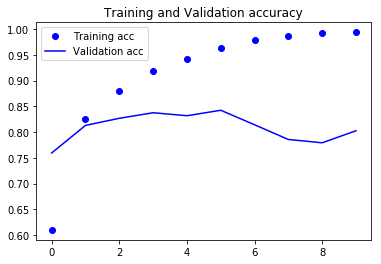

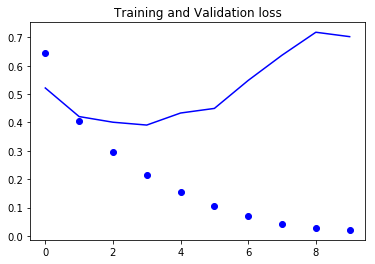

In [8]:
# リスト 6-24: 結果をプロット
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.show()

## 6.2.3 Keras での LSTM の具体的な例

In [11]:
# リスト 6-27: Keras での LSTM 層の使用
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 64s 3ms/step - loss: 0.5129 - acc: 0.7601 - val_loss: 0.3525 - val_acc: 0.8558
Epoch 2/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2920 - acc: 0.8854 - val_loss: 0.2918 - val_acc: 0.8784
Epoch 3/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2320 - acc: 0.9129 - val_loss: 0.3109 - val_acc: 0.8782
Epoch 4/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.2006 - acc: 0.9256 - val_loss: 0.3308 - val_acc: 0.8542
Epoch 5/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.1774 - acc: 0.9353 - val_loss: 0.2915 - val_acc: 0.8854
Epoch 6/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.1578 - acc: 0.9434 - val_loss: 0.3466 - val_acc: 0.8604
Epoch 7/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.1435 - acc: 0.9499 - val_loss: 0.3229 - val_acc:

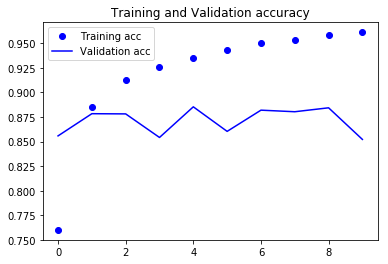

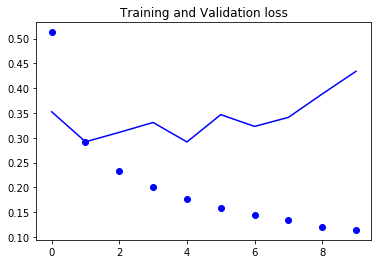

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 結果をプロットする
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.show()